# Data wrangling

## Contents
* [Data Collection](#data_collection)
* [Data Cleaning](#data_cleaning)
* [Data Definition](#data_definition)






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import difflib


## Data Collection<a id='data_collection'></a>

In [2]:
anime_raw = pd.read_csv('data/anime.csv')
anime_raw.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
rating_raw = pd.read_csv('data/rating.csv')
rating_raw.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Data Cleaning<a id='data_cleaning'></a>

In [4]:
#Cleaning common steps:
#Check missing value
#Check duplicate value
#Check data type
#Check for extreme value

In [5]:
anime_df = anime_raw.copy()
anime_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [6]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [7]:
(anime_df== 'Unknown').any()

anime_id    False
name        False
genre       False
type        False
episodes     True
rating      False
members     False
dtype: bool

In [8]:
# Replace string unknown with NaN type
anime_df.loc[(anime_df['episodes'] == 'Unknown'), 'episodes'] = np.NaN
(anime_df== 'Unknown').any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating      False
members     False
dtype: bool

In [9]:
anime_df.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64

### Convert Data type [anime_df]

In [10]:
# Convert to expected datatype
anime_df['name'] = anime_df['name'].astype('string')
anime_df['type'] = anime_df['type'].astype('string')
anime_df['genre'] = anime_df['genre'].astype('string')
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
anime_df['rating'] = anime_df['rating'].astype('float')

print(anime_df.info())
anime_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  string 
 2   genre     12232 non-null  string 
 3   type      12269 non-null  string 
 4   episodes  11954 non-null  float64
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(2), int64(2), string(3)
memory usage: 672.5 KB
None


anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64

### Fill missing value for `genre` [anime_df]

In [11]:
# Check if anime that has genre null is from the same anime but different episode title or type. Check by finding if title has similarity to other animes. 
anime_has_null_genre = anime_raw[anime_raw['genre'].isnull()]
names_without_null_genre = anime_raw[~anime_raw['genre'].isnull()]['name']
names_has_null_genre = anime_has_null_genre['name']
anime_has_null_genre['matched_name'] = names_has_null_genre.apply(lambda x: difflib.get_close_matches(x, names_without_null_genre, n=1))
anime_has_null_genre.head()

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_5063/4135770943.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_has_null_genre['matched_name'] = names_has_null_genre.apply(lambda x: difflib.get_close_matches(x, names_without_null_genre, n=1))


,anime_id,name,genre,type,episodes,rating,members,matched_name
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604,[IS: Infinite Stratos 2]
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345,[]
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313,[Metropolis]
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242,[Match Uri no Shoujo]
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607,[Sakura Taisen: Katsudou Shashin]


In [12]:
# Fill the null genre with the matched anime's genre
df_has_null_genre = anime_has_null_genre.copy()
df_has_null_genre['matched_name'] = anime_has_null_genre['matched_name'].apply(lambda x: x[0] if len(x) > 0 else np.NaN)
df_has_null_genre['matched_genre'] = df_has_null_genre['matched_name'].apply(lambda x: anime_raw[anime_raw['name']==x]['genre'].values)
df_matched_genre = df_has_null_genre.copy()
df_matched_genre['matched_genre'] = df_has_null_genre['matched_genre'].apply(lambda x: x[0] if len(x) > 0 else np.NaN)
df_matched_genre.head()

,anime_id,name,genre,type,episodes,rating,members,matched_name,matched_genre
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604,IS: Infinite Stratos 2,"Action, Comedy, Harem, Mecha, Sci-Fi"
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345,NaN,NaN
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313,Metropolis,"Adventure, Drama, Police, Romance, Sci-Fi, Sho..."
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242,Match Uri no Shoujo,"Drama, Kids"
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607,Sakura Taisen: Katsudou Shashin,"Adventure, Mecha, Sci-Fi, Shounen"


In [13]:
# Apply the filled data to anime_df
print('genre null count before: ', anime_df['genre'].isna().sum())
df_matched_genre[['anime_id', 'matched_genre']]
anime_df['genre'].fillna(df_matched_genre['matched_genre'], inplace=True)
print('genre null count after: ', anime_df['genre'].isna().sum())

genre null count before:  62
genre null count after:  14


/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_5063/2974107618.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  anime_df['genre'].fillna(df_matched_genre['matched_genre'], inplace=True)


In [14]:
anime_df.isna().sum()

anime_id      0
name          0
genre        14
type         25
episodes    340
rating      230
members       0
dtype: int64

### Fill missing value for `episodes` [anime_df]

In [15]:
# The hypothesis is that certain types will exhibit specific episode counts. For instance, movies typically have just one episode. 
# If we verify that there is a "typical" number of episodes associated with each type and this number shows little variation, 
# we will use it to impute missing episode values based on the type.

print('Missing episodes types:', anime_df[anime_df['episodes'].isna()]['type'].unique())
mean = anime_df[['type', 'episodes']].groupby('type').mean().rename(columns = {'episodes': 'mean'})
median = anime_df[['type', 'episodes']].groupby('type').median().rename(columns = {'episodes': 'median'})
std = anime_df[['type', 'episodes']].groupby('type').std().rename(columns = {'episodes': 'std'})
pd.concat((mean, median, std), axis=1)

Missing episodes types: <StringArray>
['TV', 'Special', 'ONA', 'Music', 'Movie', 'OVA', <NA>]
Length: 7, dtype: string


,mean,median,std
type,,,
Movie,1.102389,1.0,2.149296
Music,1.131417,1.0,1.293852
ONA,6.877651,2.0,11.382952
OVA,2.417663,2.0,3.208938
Special,2.561341,1.0,3.700094
TV,35.915595,24.0,80.640355


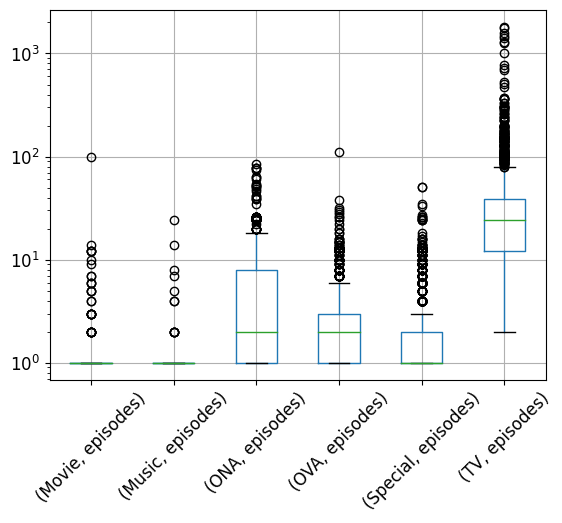

In [29]:
anime_df[['type', 'episodes']].groupby('type').boxplot(subplots=False, rot=45, fontsize=12)
plt.yscale('log')
plt.show()

Type `TV` has more extrem values and variations. Plot again without `TV`.

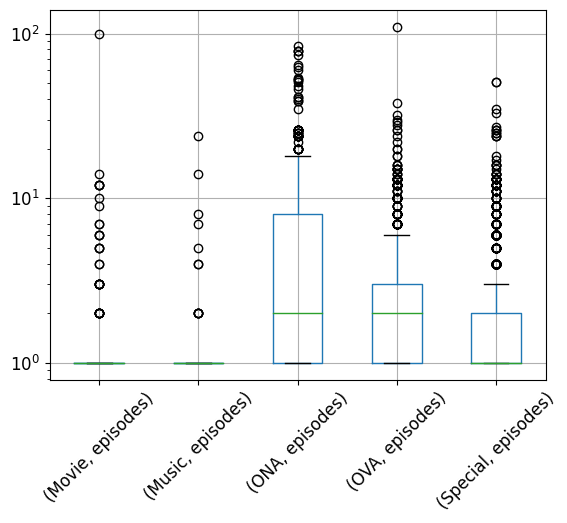

In [30]:
anime_df[anime_df['type'] != 'TV'][['type', 'episodes']].groupby('type').boxplot(subplots=False, rot=45, fontsize=12)
plt.yscale('log')
plt.show()

Only `Movie` and `Music` type has small variance of episode. Also, median is close to the rounded down of mean, so will replace the null episode value with the rounded down mean values.

In [31]:
anime_df.loc[(anime_df['type'] == 'Movie'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'Movie'), 'episodes'].fillna(value=1.0)
anime_df.loc[(anime_df['type'] == 'Music'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'Music'), 'episodes'].fillna(value=1.0)


In [32]:
anime_df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

**We decreased missing counts of episodes from 340 to 335.**

### Handle the rest of the missing values [anime_df]

In [33]:
anime_df[anime_df['type'].isna()]

,anime_id,name,genre,type,episodes,rating,members


Seems like when type is null, episodes and ratings are null as well. And we have 230 records that's missing the rating (among in total of 12294 entries). One idea is that we can fill the rating value by fuzzing matching with same anime but different episode or type, like what we did for genre. However, while it's more likely the genre would stay the same if same anime, the rating could vary depend on the season, episode or type. Thus, we will not fill the rating values. Drop the rows without ratings and episodes.

In [34]:
anime_df.dropna(inplace=True)
anime_df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

### Check duplicates [anime_df]

In [35]:
# Check duplicates
anime_df[['name', 'type']].duplicated().any()

False

### Check feature value distributions [anime_df]

In [42]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11869 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  11869 non-null  int64  
 1   name      11869 non-null  string 
 2   genre     11869 non-null  string 
 3   type      11869 non-null  string 
 4   episodes  11869 non-null  float64
 5   rating    11869 non-null  float64
 6   members   11869 non-null  int64  
dtypes: float64(2), int64(2), string(3)
memory usage: 741.8 KB


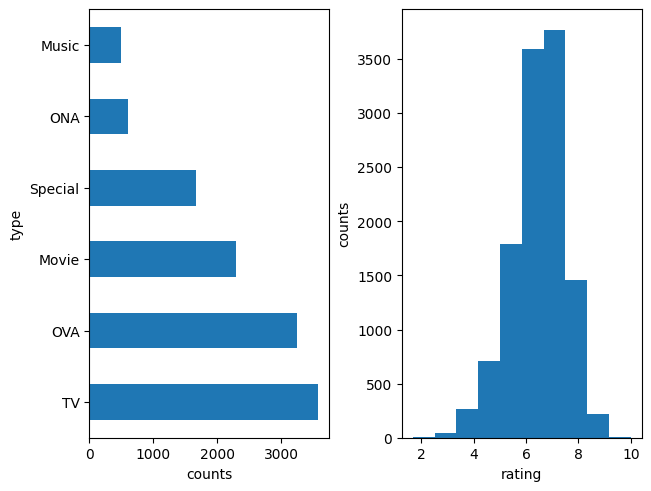

In [47]:
# Check feature outliers
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
anime_df['type'].value_counts().plot(kind='barh', ax=ax1, xlabel='counts')
anime_df['rating'].plot(kind='hist', ax = ax2, bins=10, xlabel='rating', ylabel='counts')
plt.show()

Most of the anime are type OVA and TV. And most of the rating are between 5 to 7.

In [49]:
anime_df[['rating', 'members']].describe()

,rating,members
count,11869.000000,1.186900e+04
mean,6.481038,1.845129e+04
std,1.021649,5.529020e+04
min,1.670000,1.200000e+01
25%,5.890000,2.290000e+02
50%,6.570000,1.574000e+03
75%,7.190000,9.767000e+03
max,10.000000,1.013917e+06


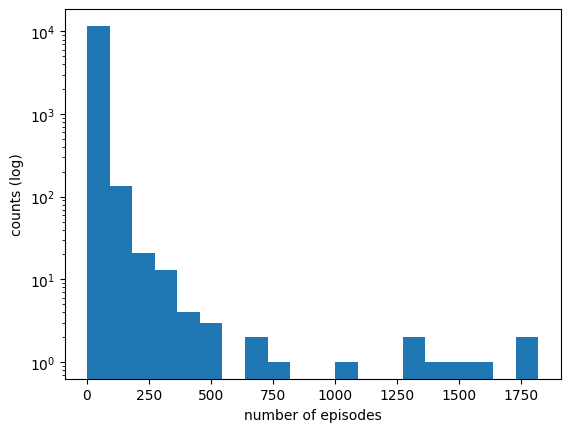

In [52]:
anime_df['episodes'].plot(kind='hist', bins=20, log= True, xlabel='number of episodes', ylabel='counts (log)')
plt.show()

Most of the anime are under 250 episodes. And we have some outliers that has 500 or more episodes.

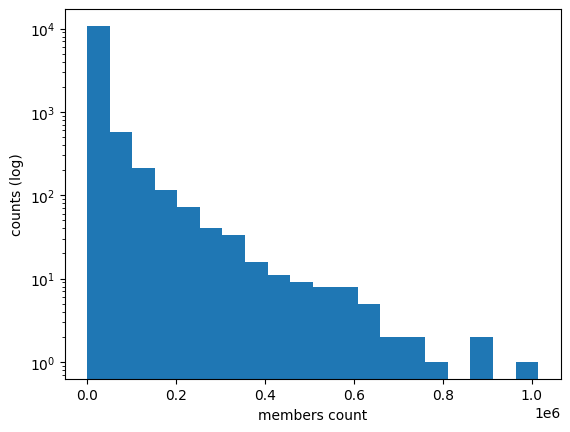

In [63]:
anime_df['members'].plot(kind='hist', bins=20, log=True, xlabel='members count', ylabel='counts (log)')
plt.show()

Most anime has lower number of member counts and the graph skew to the right.

### Split each genre into columns [anime_df]

Ok. We checked for fillable missing data, potential duplicates, feature value outliers, and the datatype. However, the genere column is a array of values. We will split each unique genere into a column with boolean value.

In [64]:
genre_columns = anime_df['genre'].str.get_dummies(sep=', ')
anime_df = pd.concat([anime_df, genre_columns], axis=1)
anime_df = anime_df.drop('genre', axis=1)
anime_df

,anime_id,name,type,episodes,rating,members,Action,Adventure,Cars,Comedy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,Movie,1.0,9.37,200630,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64.0,9.26,793665,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,TV,51.0,9.25,114262,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,TV,24.0,9.17,673572,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51.0,9.16,151266,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,OVA,1.0,4.15,211,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12290,5543,Under World,OVA,1.0,4.28,183,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12291,5621,Violence Gekiga David no Hoshi,OVA,4.0,4.88,219,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,OVA,1.0,4.98,175,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Check missing value [rating_df]

In [73]:
#Cleaning for rating
print(rating_raw.info())
rating_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [66]:
rating_raw.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### Drop duplicates

In [67]:
rating_raw[rating_raw.duplicated(keep=False)]

,user_id,anime_id,rating
4499258,42653,16498,8
4499316,42653,16498,8


In [68]:
print(rating_raw.duplicated(keep=False).sum())
rating_df = rating_raw.drop_duplicates()
print(rating_df.duplicated(keep=False).sum())

2
0


### Check feature value distributions [rating_df]¶

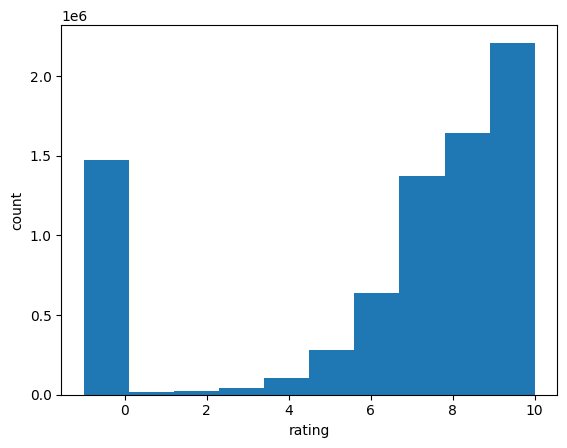

In [74]:
rating_df['rating'].plot(kind='hist', xlabel='rating', ylabel='count')
plt.show()

A lot of the ratings are in the range of 6 or above. We also see some record as -1 as rating value. This means the user watched the anime but didn't provide a rating. For the purpose of this project, we will drop the rating with -1 values.

In [76]:
rating_df = rating_df[rating_df['rating']>=0]
rating_df['rating'].unique()

array([10,  8,  6,  9,  7,  3,  5,  4,  1,  2])

## Data Definition<a id='data_definition'></a>

In [77]:
# save data
anime_df.to_csv('data/anime_df.csv', sep=',')
rating_df.to_csv('data/rating_df.csv', sep=',')
